In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import nltk
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import re, string

In [35]:
# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [36]:
# Project root directory
DATASETS_DIR = Path('../datasets/raw/toxic_comment_data')

In [37]:
# Read toxic comment datasets
train_df = pd.read_csv(DATASETS_DIR / 'train.csv')
test_df = pd.read_csv(DATASETS_DIR / 'test.csv')
test_labels_df = pd.read_csv(DATASETS_DIR / 'test_labels.csv')

In [38]:
toxicity_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['none'] = 1-train_df[toxicity_types].max(axis=1)
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
train_df.shape

(159571, 9)

since we have done EDA in 03_toxic_comment_eda.ipynb we will directly build the model

### Count Vectorizer + Naive Bayes Approach

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [41]:
def tokenize(text):
    text = re.sub(f"[{string.punctuation}]", "", text.lower())
    return text.split()

train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42)

In [42]:
# Count Vectorizer
count_vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1, 2), min_df=3)
train_count = count_vectorizer.fit_transform(train_data['comment_text'])
test_count = count_vectorizer.transform(test_data['comment_text'])

d:\IIT-J\2nd year\ML with big data\Project\youtube_comment_analysis\yca-venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
# Naive Bayes classifier for each class
nb_model = MultinomialNB()
metrics_nb = {}

for label in toxicity_types:
    nb_model.fit(train_count, train_data[label])
    preds = nb_model.predict(test_count)
    metrics_nb[label] = {
        'accuracy': accuracy_score(test_data[label], preds),
        'f1': f1_score(test_data[label], preds),
        'precision': precision_score(test_data[label], preds),
        'recall': recall_score(test_data[label], preds)
    }

print("1st Approach (Count Vectorizer + Naive Bayes) Results:", metrics_nb)

1st Approach (Count Vectorizer + Naive Bayes) Results: {'toxic': {'accuracy': 0.9362995456681811, 'f1': 0.6895709268590624, 'precision': 0.6464357286000573, 'recall': 0.7388743455497382}, 'severe_toxic': {'accuracy': 0.9853987153376156, 'f1': 0.44258373205741625, 'precision': 0.3592233009708738, 'recall': 0.5763239875389408}, 'obscene': {'accuracy': 0.9610527964906783, 'f1': 0.6657703683785964, 'precision': 0.6177644710578842, 'recall': 0.721865889212828}, 'threat': {'accuracy': 0.996960676797744, 'f1': 0.18487394957983194, 'precision': 0.24444444444444444, 'recall': 0.14864864864864866}, 'insult': {'accuracy': 0.9584208052639824, 'f1': 0.6237595690388432, 'precision': 0.575013068478829, 'recall': 0.6815365551425031}, 'identity_hate': {'accuracy': 0.9871533761554128, 'f1': 0.23220973782771537, 'precision': 0.25833333333333336, 'recall': 0.2108843537414966}}


In [44]:
data = []

# Collect data for each label from the metrics
for label in toxicity_types:
    data.append({
        'Class': label,
        'Accuracy': metrics_nb[label]['accuracy'],
        'F1 Score': metrics_nb[label]['f1'],
        'Precision': metrics_nb[label]['precision'],
        'Recall': metrics_nb[label]['recall'],
    })

# Create the DataFrame
metrics_df_nb = pd.DataFrame(data)

# Display the DataFrame
metrics_df_nb

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.936300,0.689571,0.646436,0.738874
1,severe_toxic,0.985399,0.442584,0.359223,0.576324
2,obscene,0.961053,0.665770,0.617764,0.721866
3,threat,0.996961,0.184874,0.244444,0.148649
4,insult,0.958421,0.623760,0.575013,0.681537
5,identity_hate,0.987153,0.232210,0.258333,0.210884


### TF-IDF + Logistic Regression Approach

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [46]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), min_df=3, max_df=0.9)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['comment_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['comment_text'])

d:\IIT-J\2nd year\ML with big data\Project\youtube_comment_analysis\yca-venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:
# Logistic Regression classifier for each class
lr_model = LogisticRegression(max_iter=1000)
metrics_lr = {}
lr_models = {}

# Use train_data to fit the model
for label in toxicity_types:
    lr_model.fit(train_tfidf, train_data[label])  # Corrected to use train_data
    preds = lr_model.predict(test_tfidf)
    metrics_lr[label] = {
        'accuracy': accuracy_score(test_data[label], preds),
        'f1': f1_score(test_data[label], preds),
        'precision': precision_score(test_data[label], preds),
        'recall': recall_score(test_data[label], preds)
    }
    lr_models[label] = lr_model
print("2nd Approach (TF-IDF + Logistic Regression) Results:", metrics_lr)

2nd Approach (TF-IDF + Logistic Regression) Results: {'toxic': {'accuracy': 0.9535014883283722, 'f1': 0.6956521739130435, 'precision': 0.9318681318681319, 'recall': 0.5549738219895288}, 'severe_toxic': {'accuracy': 0.9904433651887827, 'f1': 0.2823529411764706, 'precision': 0.5769230769230769, 'recall': 0.18691588785046728}, 'obscene': {'accuracy': 0.9734294219019269, 'f1': 0.6886930983847284, 'precision': 0.929633300297324, 'recall': 0.5469387755102041}, 'threat': {'accuracy': 0.9978693404355319, 'f1': 0.20930232558139536, 'precision': 0.75, 'recall': 0.12162162162162163}, 'insult': {'accuracy': 0.9692934356885478, 'f1': 0.608, 'precision': 0.8577878103837472, 'recall': 0.4708798017348203}, 'identity_hate': {'accuracy': 0.9916026946576845, 'f1': 0.21176470588235294, 'precision': 0.782608695652174, 'recall': 0.12244897959183673}}


In [48]:
data = []

# Collect data for each label from the metrics
for label in toxicity_types:
    data.append({
        'Class': label,
        'Accuracy': metrics_lr[label]['accuracy'],
        'F1 Score': metrics_lr[label]['f1'],
        'Precision': metrics_lr[label]['precision'],
        'Recall': metrics_lr[label]['recall'],
    })

# Create the DataFrame
metrics_df_lr = pd.DataFrame(data)

# Display the DataFrame
metrics_df_lr

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.953501,0.695652,0.931868,0.554974
1,severe_toxic,0.990443,0.282353,0.576923,0.186916
2,obscene,0.973429,0.688693,0.929633,0.546939
3,threat,0.997869,0.209302,0.750000,0.121622
4,insult,0.969293,0.608000,0.857788,0.470880
5,identity_hate,0.991603,0.211765,0.782609,0.122449


### Word Embeddings (GloVe) + LSTM Approach

In [49]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [50]:
# Tokenization using Keras Tokenizer
tokenizer = Tokenizer(num_words=20000)  # Limit vocabulary size
tokenizer.fit_on_texts(train_data['comment_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['comment_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])

In [51]:
# Padding sequences to ensure same length
max_seq_len = 100
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len)
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len)

In [52]:
# Load GloVe embeddings (GloVe embeddings are pre-downloaded)
embedding_index = {}

with open("../datasets/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [53]:
# Prepare embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [54]:
# LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(6, activation='sigmoid')  # 6 output neurons for multi-label classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# Build and train the LSTM model
lstm_model = build_lstm_model()
lstm_model.fit(train_padded, train_data[toxicity_types].values, epochs=3, batch_size=128, validation_split=0.1)

d:\IIT-J\2nd year\ML with big data\Project\youtube_comment_analysis\yca-venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 112s 119ms/step - accuracy: 0.5267 - loss: 0.1442 - val_accuracy: 0.9930 - val_loss: 0.0631
Epoch 2/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 93s 104ms/step - accuracy: 0.8777 - loss: 0.0634 - val_accuracy: 0.9939 - val_loss: 0.0586
Epoch 3/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.9428 - loss: 0.0588 - val_accuracy: 0.9939 - val_loss: 0.0570


In [56]:
# Evaluate on test data
lstm_preds = lstm_model.predict(test_padded)
metrics_lstm = {}

for i, label in enumerate(toxicity_types):
    lstm_bin_preds = (lstm_preds[:, i] > 0.5).astype(int)
    metrics_lstm[label] = {
        'accuracy': accuracy_score(test_data[label], lstm_bin_preds),
        'f1': f1_score(test_data[label], lstm_bin_preds),
        'precision': precision_score(test_data[label], lstm_bin_preds),
        'recall': recall_score(test_data[label], lstm_bin_preds)
    }

print("3rd Approach (Word Embeddings + LSTM) Results:", metrics_lstm)

998/998 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step
3rd Approach (Word Embeddings + LSTM) Results: {'toxic': {'accuracy': 0.95729280902397, 'f1': 0.7421002838221381, 'precision': 0.879766711529834, 'recall': 0.6416884816753927}, 'severe_toxic': {'accuracy': 0.9902553658154473, 'f1': 0.07164179104477612, 'precision': 0.8571428571428571, 'recall': 0.037383177570093455}, 'obscene': {'accuracy': 0.9765627447908507, 'f1': 0.7555555555555555, 'precision': 0.8594795539033457, 'recall': 0.6740524781341107}, 'threat': {'accuracy': 0.9976813410621964, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}, 'insult': {'accuracy': 0.9691681027729907, 'f1': 0.6500711237553343, 'precision': 0.7629382303839732, 'recall': 0.5662949194547707}, 'identity_hate': {'accuracy': 0.990882030393232, 'f1': 0.026755852842809364, 'precision': 0.8, 'recall': 0.013605442176870748}}


d:\IIT-J\2nd year\ML with big data\Project\youtube_comment_analysis\yca-venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
data = []

# Collect data for each label from the metrics
for label in toxicity_types:
    data.append({
        'Class': label,
        'Accuracy': metrics_lstm[label]['accuracy'],
        'F1 Score': metrics_lstm[label]['f1'],
        'Precision': metrics_lstm[label]['precision'],
        'Recall': metrics_lstm[label]['recall'],
    })

# Create the DataFrame
metrics_df_lstm = pd.DataFrame(data)

# Display the DataFrame
metrics_df_lstm

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.957293,0.742100,0.879767,0.641688
1,severe_toxic,0.990255,0.071642,0.857143,0.037383
2,obscene,0.976563,0.755556,0.859480,0.674052
3,threat,0.997681,0.000000,0.000000,0.000000
4,insult,0.969168,0.650071,0.762938,0.566295
5,identity_hate,0.990882,0.026756,0.800000,0.013605


### comparing all the models

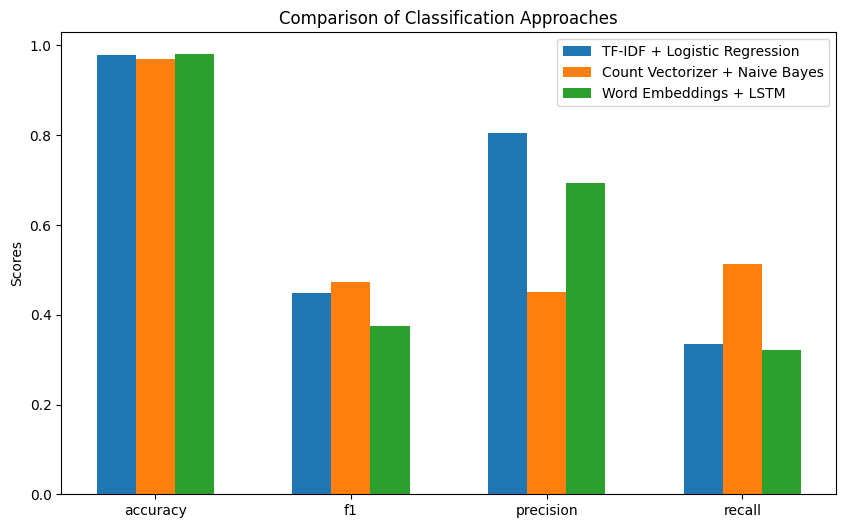

In [58]:
# Extracting average scores from each approach for all metrics
approach_metrics = {
    'TF-IDF + Logistic Regression': metrics_lr,
    'Count Vectorizer + Naive Bayes': metrics_nb,
    'Word Embeddings + LSTM': metrics_lstm
}

# Averaging the metrics across all six labels
def average_metrics(metrics_dict):
    avg_metrics = {'accuracy': [], 'f1': [], 'precision': [], 'recall': []}
    for metric in avg_metrics:
        avg_metrics[metric] = np.mean([metrics_dict[label][metric] for label in toxicity_types])
    return avg_metrics

# Calculate average metrics for each approach
avg_metrics_lr = average_metrics(metrics_lr)
avg_metrics_nb = average_metrics(metrics_nb)
avg_metrics_lstm = average_metrics(metrics_lstm)

# Data for bar plot
labels = ['accuracy', 'f1', 'precision', 'recall']
lr_scores = [avg_metrics_lr[m] for m in labels]
nb_scores = [avg_metrics_nb[m] for m in labels]
lstm_scores = [avg_metrics_lstm[m] for m in labels]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, lr_scores, width, label='TF-IDF + Logistic Regression')
ax.bar(x, nb_scores, width, label='Count Vectorizer + Naive Bayes')
ax.bar(x + width, lstm_scores, width, label='Word Embeddings + LSTM')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Classification Approaches')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

### Summary: 

1. Count Vectorizer + Naive Bayes

    Accuracy: Decent (~0.93 to 0.98)

    F1 Scores: Moderate (e.g., 0.68 for toxic, 0.44 for severe_toxic, very low for threat)

    Recall: Stronger than TF-IDF in some classes (like insult)

    But fails badly on threat (F1 = 0.18) and identity_hate (F1 = 0.23)

2. TF-IDF + Logistic Regression

    Highest accuracy across most classes (esp. threat, insult, identity_hate)

    High precision (esp. toxic, obscene, threat, insult)

    Weak recall on multiple classes (threat, severe_toxic, identity_hate)

    Lower F1 score on some classes due to imbalance between precision & recall

3. Word Embeddings + LSTM

    Best F1 scores overall (especially toxic, obscene, insult)

    Balanced precision and recall for key labels

    However, completely fails on threat and identity_hate (F1 = 0), indicating class imbalance issues or model underfitting those classes

In [59]:
# Create a list to hold the data for the DataFrame
data = []

# Collect data for each class from all models
for class_label in label_cols:
    data.append({
        'Class': class_label,
        'TF-IDF + Logistic Regression Accuracy': metrics_lr[class_label]['accuracy'],
        'TF-IDF + Logistic Regression F1 Score': metrics_lr[class_label]['f1'],
        'TF-IDF + Logistic Regression Precision': metrics_lr[class_label]['precision'],
        'TF-IDF + Logistic Regression Recall': metrics_lr[class_label]['recall'],
        'Count Vectorizer + Naive Bayes Accuracy': metrics_nb[class_label]['accuracy'],
        'Count Vectorizer + Naive Bayes F1 Score': metrics_nb[class_label]['f1'],
        'Count Vectorizer + Naive Bayes Precision': metrics_nb[class_label]['precision'],
        'Count Vectorizer + Naive Bayes Recall': metrics_nb[class_label]['recall'],
        'Word Embeddings + LSTM Accuracy': metrics_lstm[class_label]['accuracy'],
        'Word Embeddings + LSTM F1 Score': metrics_lstm[class_label]['f1'],
        'Word Embeddings + LSTM Precision': metrics_lstm[class_label]['precision'],
        'Word Embeddings + LSTM Recall': metrics_lstm[class_label]['recall'],
    })

# Create the DataFrame
metrics_df = pd.DataFrame(data)

metrics_df_rotated = metrics_df.T

# Display the rotated DataFrame
metrics_df_rotated

NameError: name 'label_cols' is not defined

#### Conclusion:
By looking at the above summary we will use the TF-IDF + Logistic Regression model

### Saving the Model

In [ ]:
import pickle

In [ ]:
# Save the TF-IDF vectorizer
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the Logistic Regression models
with open('../models/lr_models.pkl', 'wb') as f:
    pickle.dump(lr_models, f)

In [ ]:
# 5. Verification step
print("\nVerifying models...")
# Test prediction on a sample
sample_text = test_data['comment_text'].iloc[0]
sample_tfidf = tfidf_vectorizer.transform([sample_text])
print("\nPredictions for sample text:")
for label in toxicity_types:
    pred = lr_models[label].predict(sample_tfidf)[0]
    print(f"{label}: {pred}")


Verifying models...

Predictions for sample text:
toxic: 0
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0
